In [242]:
import pandas as pd
import numpy as np

# show all the columns from the data frame
pd.set_option('display.max_columns', None)

# import pregressing bar for visualization
from tqdm import tqdm
tqdm.pandas(desc = "Progressing Bar")

# import regular expression for string matching 
import re

# import graphing packages
import matplotlib.pyplot as plt
import seaborn as sns

# import natural language toolkit
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer  
le = WordNetLemmatizer()

# import vectorizer and model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

## Import Text Dataset

In [243]:
# import text data
demo_def = pd.read_csv("/Users/evagao/Desktop/demo.def.csv")
demo_def.shape
display(demo_def)

,doc_id,country,text
0,1,Mainland China,Freedom of speech/press/expression
1,2,Mainland China,Freedom of belief
2,3,Mainland China,Freedom of speech/press/expression
3,4,Mainland China,Freedom from government repression
4,5,Mainland China,Freedom of speech/press/expression
...,...,...,...
15282,15283,Thailand,Freedom in general
15283,15284,Thailand,Freedom in general
15284,15285,Thailand,"Election, popular vote or electoral choice"
15285,15286,Thailand,Non discrimination


## Data Cleaning - Tokenization and Lemmatization

In [244]:
def clean_documents(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z#]", ' ', text)
    word_tokens = nltk.word_tokenize(text)
    tokens = [le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w) > 3]
    cleaned_text =" ".join(tokens)
    
    return cleaned_text

# tokenize and lemmatize the text inputs
demo_def['clean_document'] = demo_def['text'].progress_apply(lambda x: clean_documents(x))
demo_def.drop(columns = 'doc_id')

Progressing Bar: 100%|██████████| 15287/15287 [00:01<00:00, 13831.73it/s]


,country,text,clean_document
0,Mainland China,Freedom of speech/press/expression,freedom speech press expression
1,Mainland China,Freedom of belief,freedom belief
2,Mainland China,Freedom of speech/press/expression,freedom speech press expression
3,Mainland China,Freedom from government repression,freedom government repression
4,Mainland China,Freedom of speech/press/expression,freedom speech press expression
...,...,...,...
15282,Thailand,Freedom in general,freedom general
15283,Thailand,Freedom in general,freedom general
15284,Thailand,"Election, popular vote or electoral choice",election popular vote electoral choice
15285,Thailand,Non discrimination,discrimination


In [245]:
# returns top n words as specified in a sample and their accompanying counts
# referenced from online sources, sources provided in the final report
def get_top_n_words(n_top_words, count_vectorizer, text_data):

    vectorized_text = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_text, axis = 0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_text.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis = 1).tolist()
    return keys

# returns a topic categories with magnitudes for keys
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

## Top N Words Visualization

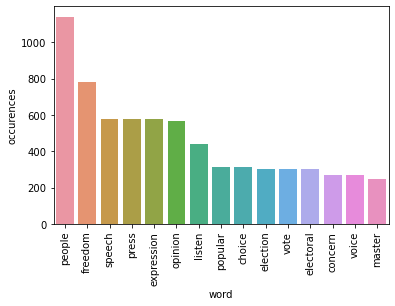

In [309]:
count_vectorizer = CountVectorizer(stop_words = 'english')
words, word_values = get_top_n_words(n_top_words = 15,
                                     count_vectorizer = count_vectorizer, 
                                     text_data = demo_def.loc[demo_def['country'] == "Mainland China"]['clean_document'])

words_n_values = pd.DataFrame({'word' : range(len(words)), 'occurences' : word_values})
ax = sns.barplot(x = words_n_values['word'], y = words_n_values['occurences'])
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation = 'vertical')
plt.show()

## Model Fitting - Latent Semantic Analysis

In [332]:
# generate tf-idf matrix
vect = TfidfVectorizer(stop_words = stop_words, max_features = 4000)

# fit and transform the cleaned text data
vect_text = vect.fit_transform(demo_def.loc[demo_def['country'] == "Mainland China"]['clean_document'])

# create a Latent Semantic Analysis
lsa_model = TruncatedSVD(n_components=1, algorithm = 'randomized', n_iter=20)

# fit the model with text data
lsa_top = lsa_model.fit_transform(vect_text)

## Word Cloud Visualization

In [333]:
# import package for visualizing the word cloud
!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud

# Generate a word cloud image for given topic
def draw_word_cloud(index, model):
    imp_words_topic = ""
    comp = model.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key = lambda x:x[1], reverse = True)[:50]
    for word in sorted_words:
        imp_words_topic = imp_words_topic + " " + word[0]

    wordcloud = WordCloud(width=600, height=400, colormap='Dark2', background_color="white").generate(imp_words_topic)
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()

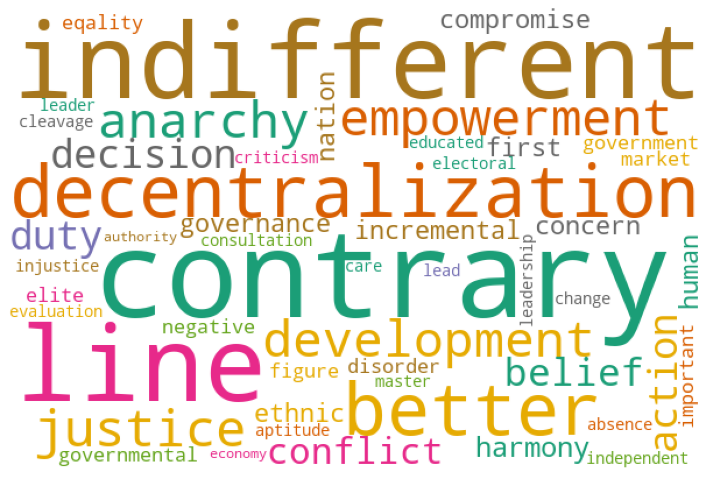

In [334]:
draw_word_cloud(0, lsa_model)